In [46]:
function shannonentropy{T}(V::AbstractVector{T})
    H = zero(T)
    for i=1:length(V)
        V[i]==0 && continue
        H -= V[i]*log2(V[i])
    end
    H
end    

shannonentropy (generic function with 1 method)

In [125]:
function symKL{T}(p::AbstractMatrix{T}, q::AbstractMatrix{T})
    C = zero(T)
    m, n = size(p)
    @assert (m, n) == size(q)
    for i=1:m, j=1:n
        #i==j && continue
        p[i,j]==0 && continue
        q[i,j]==0 && continue
        C += p[i,j] * log(p[i,j]/q[i,j])
    end
    C
end

symKL (generic function with 1 method)

In [48]:
#Jacobs' learning rate updating rule
function learnupdate(ϵ, δ, δ̄ , θ=0.2, ϕ=0.5, κ=0.5)
    test = δ̄ *δ
    δ̄ = (1-θ)*δ + θ*δ̄ 
    Δϵ = if test > 0
            κ
        elseif test < 0
            -ϕ*ϵ
        else
            0.0
        end
    Δϵ, δ̄ 
end

learnupdate (generic function with 4 methods)

In [49]:
function tsne{S<:Real}(X::Matrix{S}, σ::Vector{S},
        Y=randn(k, size(X, 2))*1e-4, k::Int=2, T::Int=1000, η=100)
    
    m, n = size(X)
    @assert length(σ) == n
    #Compute pairwise affinities
    p = zeros(S, n, n)
    psum = zero(S)
    for i=1:n, j=1:n
        thisp = exp(-norm(slice(X, :, i) - slice(X, :, j))^2/(2σ[i]^2))
        p[j, i] = thisp
        psum += thisp
    end
    scale!(p, 1/psum)
    #Compute Shannon entropy
    for i=1:n
        H = shannonentropy(slice(p, :, i))
        info("Entropy_i = $H, perplexity = $(2^H) (5--50 recommended)")
    end
    #Symmetrize
    p = (p + p')/(2n)
    #Sample initial solution
    Y₋= zeros(k, n)
    δ̄ = zeros(k, n) #Used for weighted update
    ηs= fill(float(η), k, n)
    cost = Inf
    for t=1:T
        #Compute low-dimensional affinities
        q = zeros(n, n)
        qsum = 0.0
        for i=1:n, j=1:n
            δy = slice(Y, :, i) - slice(Y, :, j)
            thisq = 1/(1 + δy⋅δy)
            q[i,j] = thisq
            i==j || (qsum += thisq)
        end
        scale!(q, 1/qsum)
        #Compute δC_δy
        δC_δy = zeros(k, n)
        exag = t<50 ? 4.0 : 1.0 #"early exaggeration" 
        for i=1:n, j=1:n
            j==i && continue
            δC_δy[:, i] += 4*(exag*p[i,j] - q[i,j])*
            (Y[:, i] - Y[:, j])/
            (1 + norm(slice(Y, :, i) - slice(Y, :, j))^2)
        end
        α = t<250 ? 0.5 : 0.8
        #Update Y
        Y, Y₋ = Y + η.*δC_δy + α*(Y-Y₋), Y
        #Update η (Jacobs, 1988)
        for i=1:n, j=1:k
            Δϵ, δ̄ [j, i] = learnupdate(ηs[j, i], δC_δy[j, i], δ̄ [j, i])
            ηs[j, i] += Δϵ
        end
        #Print cost function
        cost, oldcost = symKL(p, q), cost
        info("Iteration $t: cost = $cost")
        abs(cost - oldcost) <= 1e-9*abs(cost) && break
    end
    Y
end

tsne (generic function with 5 methods)

In [50]:
#Do t-SNE with quasi-Newton

In [51]:
function backtracklinesearch(p, x, f, df_dx, α=1.0, c=0.5, τ=0.5, maxiter::Int=10)
    m = p⋅df_dx
    t = -c*m
    for j = 1:maxiter
        f(x) - f(x+α*p) ≥ α*t && break 
        α *= τ
        j==maxiter && (warn("Maxiter reached"); return 0.0)
    end
    α
end

backtracklinesearch (generic function with 5 methods)

In [139]:
function compute_dC_dq(Y, p, q)
    k, n = size(Y)
    δC_δy = zeros(k, n)
    for i=1:n, j=1:n
        #i==j && continue
        d = norm(slice(Y, :, i) - slice(Y, :, j))
        δC_δy[:, i] += 4*(p[i,j] - q[i,j])*
        (Y[:, i] - Y[:, j])*
        1/(1 + d^2) #Factor of d is absent in papar
        @show i, j, δC_δy[:, i]
    end
    δC_δy
end

compute_dC_dq (generic function with 1 method)

In [162]:
function g_tsne!(
	gr::Matrix{Float64},
	P::Matrix{Float64},
	Q::Matrix{Float64},
	Y::Matrix{Float64},
)
	k, n = size(Y)
	fill!(gr, 0.0)
	for dim in 1:k
		for i in 1:n
			for j in 1:n
				if i != j
                    prdiff = (P[i, j] - Q[i, j])
                    D2_Y = norm(Y[:, i] - Y[:, j])^2
					tkern = 1 / (1 + D2_Y)
					gr[dim, i] += 4 * prdiff * (Y[dim, i] - Y[dim, j]) * tkern
				end
			end
		end
	end
    gr
end

g_tsne! (generic function with 2 methods)

In [164]:
let #Check derivative by finite central difference
Y=[1. 2.1; 13 4];#zeros(2,4)#randn(2,4)
q=computeq(Y)
@assert q==[0 0.5; 0.5 0]
p=ones(2,2)-eye(2,2)

@show g_tsne!(zeros(2,2), p, q, Y)    
C=symKL(p, q)
@assert C==2log(2)
dC_dq = compute_dC_dq(Y, p, q)
dC_dq_f = similar(dC_dq)
ϵ = 1e-6
for i=1:size(Y,1), j=1:size(Y,2)
    Y[i,j] += ϵ
    q2=computeq(Y)
    @show C2=symKL(p,q2)
    Y[i,j] -= 2ϵ
    q3=computeq(Y)
    @show C3=symKL(p,q3)
    Y[i,j] += ϵ
    dC_dq_f[i,j] = (C2 - C3)/(2ϵ)
end
[dC_dq[:] dC_dq_f[:]]
end

g_tsne!(zeros(2,2),p,q,Y) => [-0.026439129912270157 0.026439129912270157
 0.2163201538276649 -0.2163201538276649]
(i,j,δC_δy[:,i]) => (1,1,[0.0,0.0])
(i,j,δC_δy[:,i]) => (1,2,[-0.026439129912270154,0.2163201538276649])
(i,j,δC_δy[:,i]) => (2,1,[0.026439129912270154,-0.2163201538276649])
(i,j,δC_δy[:,i]) => (2,2,[0.026439129912270154,-0.2163201538276649])
C2 = symKL(p,q2) => 1.3862943611198906
C3 = symKL(p,q3) => 1.3862943611198906
C2 = symKL(p,q2) => 1.3862943611198906
C3 = symKL(p,q3) => 1.3862943611198906
C2 = symKL(p,q2) => 1.3862943611198906
C3 = symKL(p,q3) => 1.3862943611198906
C2 = symKL(p,q2) => 1.3862943611198906
C3 = symKL(p,q3) => 1.3862943611198906


4x2 Array{Float64,2}:
 -0.0264391  0.0
  0.21632    0.0
  0.0264391  0.0
 -0.21632    0.0

In [151]:
function computeq(Y)
    n = size(Y, 2)
    q = zeros(n, n)
    qsum = 0.0
    for i=1:n, j=1:n
        i==j && continue
        δy = slice(Y, :, i) - slice(Y, :, j)
        thisq = 1/(1 + δy⋅δy)
        q[i,j] = thisq
        qsum += thisq
    end
    scale!(q, 1/qsum)
end

computeq (generic function with 1 method)

In [86]:
function tsne_bfgs{S<:Real}(X::Matrix{S}, σ::Vector{S},
        Y=randn(k, size(X, 2))*1e-4, k::Int=2, T::Int=1000, η=100)
    
    m, n = size(X)
    @assert length(σ) == n
    #Compute pairwise affinities
    p = zeros(S, n, n)
    psum = zero(S)
    for i=1:n, j=1:n
        p[j, i] = thisp = exp(-norm(slice(X, :, i) - slice(X, :, j))^2/(2σ[i]^2))
        psum += thisp
    end
    scale!(p, 1/psum)

    #Compute Shannon entropy
#      for i=1:n
#          H = shannonentropy(slice(p, :, i))
#          info("Entropy_i = $H, perplexity = $(2^H) (5--50 recommended)")
#      end
    #Symmetrize
    p = (p + p')/(2n)
        
    cost = Inf
    computeHessian=true
    for t=1:T
        #Compute low-dimensional affinities
        q = computeq(Y)
        #Compute δC_δy
        δC_δy = compute_dC_dq(Y, p, q)

        #Compute Hessian
        #Initialize pseudo-Hessian
        if computeHessian
            B = spzeros(k*n, k*n)
            #B = zeros(k*n, k*n)
            q = computeq(Y)
            for i=1:n, kk=1:n
                d = norm(slice(Y,:,i)-slice(Y,:,kk))
                for l=1:k
                    B[(i-1)*k+l,(i-1)*k+l] += 4*(p[i,kk]-q[i,kk])*d/(1+d^2)
                end
            end
            computeHessian = false
        end
            
        #Search direction
        px = -B\δC_δy[:]
        
        #Backtracking line search
        α = backtracklinesearch(px, Y[:], y->symKL(p, computeq(reshape(y,k,n))), δC_δy[:])
        computeHessian = α==0
        
        sx = α*px
        Y=Y+reshape(sx, k, n)
        yx = compute_dC_dq(Y, p, computeq(Y))[:] - δC_δy[:]
        
        tx = B*sx
        B = B + yx*yx'/(yx⋅sx) - tx*tx'/(sx⋅tx)

        #Print cost function
        cost, oldcost = symKL(p, q), cost
        info("Iteration $t: cost = $cost")
        abs(cost - oldcost) <= 1e-9*abs(cost) && break
    end
    Y
end

tsne_bfgs (generic function with 5 methods)

In [55]:
using MNIST
n=100
X = testdata()[1][:,1:n]
digitid = int(testdata()[2][1:n])

100-element Array{Int64,1}:
 7
 2
 1
 0
 4
 1
 4
 9
 5
 9
 0
 6
 9
 ⋮
 6
 1
 3
 6
 9
 3
 1
 4
 1
 7
 6
 9

In [89]:
Y = std(X, 1)[:]
Y0 = randn(2,n)
@time Y1 = tsne(X, Y, Y0)

INFO: Entropy_i = 0.06643856189774724, perplexity = 1.0471285480508996 (5--50 recommended)
INFO: Entropy_i = 0.06643856189774724, perplexity = 1.0471285480508996 (5--50 recommended)
INFO: Entropy_i = 0.06643856189774724, perplexity = 1.0471285480508996 (5--50 recommended)
INFO: Entropy_i = 0.06643856189774724, perplexity = 1.0471285480508996 (5--50 recommended)
INFO: Entropy_i = 0.06643856189774724, perplexity = 1.0471285480508996 (5--50 recommended)
INFO: Entropy_i = 0.06643856189774724, perplexity = 1.0471285480508996 (5--50 recommended)
INFO: Entropy_i = 0.06643856189774724, perplexity = 1.0471285480508996 (5--50 recommended)
INFO: Entropy_i = 0.06643856189774724, perplexity = 1.0471285480508996 (5--50 recommended)
INFO: Entropy_i = 0.06643856189774724, perplexity = 1.0471285480508996 (5--50 recommended)
INFO: Entropy_i = 0.06643856189774724, perplexity = 1.0471285480508996 (5--50 recommended)
INFO: Entropy_i = 0.06643856189774724, perplexity = 1.0471285480508996 (5--50 recommended)

elapsed time: 81.504547474 seconds (14369878948 bytes allocated, 19.63% gc time)


2x100 Array{Float64,2}:
 0.0790086    0.209798  -0.0102022  …  -0.0460909  -0.0860516   0.145683 
 0.00217198  -0.197192  -0.337029      -0.0135674  -0.293154   -0.0305904

In [90]:
@time Y2 = tsne_bfgs(X, Y, Y0)

INFO: Iteration 1: cost = -1.1248281842246866e-37
INFO: Iteration 2: cost = -1.1409852302274642e-37
INFO: Iteration 3: cost = -1.110581962064449e-37
INFO: Iteration 4: cost = -1.11800255148206e-37
INFO: Iteration 5: cost = -1.145794100130612e-37
INFO: Iteration 6: cost = -1.1446848702216755e-37
INFO: Iteration 7: cost = -1.1371102832021675e-37
INFO: Iteration 8: cost = -1.1379582603826318e-37
INFO: Iteration 9: cost = -1.143230834946396e-37
INFO: Iteration 10: cost = -1.1423311064246564e-37
INFO: Iteration 11: cost = -1.1476321803026102e-37
INFO: Iteration 12: cost = -1.1449882206711082e-37
INFO: Iteration 13: cost = -1.1471932324478668e-37
INFO: Iteration 14: cost = -1.1445976871319893e-37
INFO: Iteration 15: cost = -1.0851920554664283e-37
INFO: Iteration 16: cost = -1.0817489309008143e-37
INFO: Iteration 17: cost = -1.093603749782947e-37
INFO: Iteration 18: cost = -1.136308576474094e-37
INFO: Iteration 19: cost = -1.0933797440570725e-37
INFO: Iteration 20: cost = -1.0924300385906113e

elapsed time: 16.64410318 seconds (3168868744 bytes allocated, 19.36% gc time)


2x100 Array{Float64,2}:
 -8852.92  -14918.4   76523.6  -111491.0  …  -23455.8   7470.82  11023.7
 -4940.85    7457.33  55375.5   -21020.0     -41786.7  45960.7   35710.1

In [58]:
#using Gadfly
#spy(X)

In [59]:
# hstack(
# plot(x=Y1[1,:], y=Y1[2,:], color=cm),
# plot(x=Y2[1,:], y=Y2[2,:], color=cm)
# )

In [60]:
using Color
using Compose
using Gadfly
using Interact

In [61]:
@manipulate for i=1:size(X, 2)
    map(x->Color.RGB(fill(1-x/255, 3)...), reshape(sub(X, :, i), 28, 28))
end

Slider{Int64}([Input{Int64}] 50,"i",50,1:100)

In [73]:
function simpleplot(Y2, fillcolors=fill("black", size(Y2, 2)))
    pixels = Any[]
    x₋ = Y2[1, 1]
    x₊ = Y2[1, 1]
    y₋ = Y2[2, 1]
    y₊ = Y2[2, 1]
    for i=1:size(Y2, 2)
        x = Y2[1, i]
        y = Y2[2, i]
        x₋ = min(x, x₋)
        x₊ = max(x, x₊)
        y₋ = min(y, y₋)
        y₊ = max(y, y₊)
    end
    r = 0.02*(x₊-x₋)
    for i=1:size(Y2, 2)
        x = Y2[1, i]
        y = Y2[2, i]
        push!(pixels,
            compose(context(), circle(x, y, r), fill(fillcolors[i]))
        )
    end
    compose(context(units=UnitBox(x₋-r, y₋-r, x₊-x₋+2r, y₊-y₋+2r)),
       pixels...)
end

simpleplot (generic function with 2 methods)

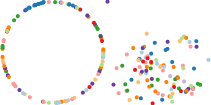

In [88]:
using ColorBrewer
cmap = palette("Paired", 10)
ycm = map(x->cmap[x+1], digitid)
draw(SVG(800px,400px),
    hstack(simpleplot(Y1, ycm), simpleplot(Y2, ycm))
)

In [72]:
Y2

2x100 Array{Float64,2}:
 -0.121941   -0.122116   -0.12341    …  -0.122962   -0.122696   -0.12481 
  0.0275557   0.0298718   0.0322706      0.0320158   0.0311131   0.029159

In [64]:
function hessian(Y, p, q)
    n = size(Y, 2)
    H = zeros(n, n)

    #Term 1
    #for i=1:n, j=1:n
    #    H[i, j] -= 4*(p[i,j]-q[i,j])*d/(1+d^2)#*(y[i]-y[j])
    #end
    #Term 2
    #for i=1:n, j=1:n
    #    H[i, j] += 4*(p[i,j]-q[i,j])*d/(1+d^2)#*(y[i]-y[j])
    #end
    #Term 3
    for i=1:n, j=1:n
        if i==j
            for k=1:n
                d = norm(slice(Y,:,i)-slice(Y,:,k))
                H[i,j] += 4*(p[i,k]-q[i,k])*d/(1+d^2)
            end
        end
        d = norm(slice(Y,:,j)-slice(Y,:,j))
        H[i,j] -= 4*(p[i,j]-q[i,j])*d/(1+d^2)
    end
    H
end    

hessian (generic function with 2 methods)